In [149]:
import torch
import matplotlib.pyplot as plt
from torch import nn

In [150]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right


raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()


# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)

word_to_ix = {word: i for i, word in enumerate(vocab)}

data = []

for i in range(2, len(raw_text) - 2):
    context = [raw_text[i - 2], raw_text[i - 1],
               raw_text[i + 1], raw_text[i + 2]]
    target = raw_text[i]
    data.append((context, target))

print(data[:5])

# create your model and train.  here are some functions to help you make
# the data ready for use by your module


def make_context_vector(context, word_to_ix):
    if type(context) is list:
        idxs = [word_to_ix[w] for w in context]
        return torch.tensor(idxs, dtype=torch.long)
    else:
        return torch.tensor([word_to_ix[context]], dtype=torch.long)


make_context_vector(data[0][0], word_to_ix)  # example

[(['We', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'a'], 'idea')]


tensor([48, 15, 18, 47])

In [151]:
ix_to_word = {
    word_to_ix[key]: key
    for key in word_to_ix
}

In [152]:
def similarity(a, b):
    return a.matmul(b.t()) / (a.norm() * b.norm())

In [153]:
criterion = nn.NLLLoss()

In [154]:
class CBOW(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()
        
        self.linear2 = nn.Linear(128, vocab_size)
        self.activation_function2 = nn.LogSoftmax(dim=-1)
        

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1, -1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        out = self.activation_function2(out)
        return out

    def get_embeddings(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1, -1)
        return embeds

In [155]:
model = CBOW(vocab_size, 16)

In [156]:
inputs = make_context_vector(data[0][0], word_to_ix)
target = torch.tensor([word_to_ix[data[0][1]]]).long()

print(inputs, target)

criterion(model(inputs), target)

tensor([48, 15, 18, 47]) tensor([28])


tensor(4.4192, grad_fn=<NllLossBackward>)

In [157]:
model.train()

DISPLAY_EACH_EPOCH = 100
EPOCHES = 2000

losses = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(EPOCHES):
    model.zero_grad()
    
    total_loss = 0
    for context, target in data:
        inputs = make_context_vector(context, word_to_ix)
        target = torch.tensor([word_to_ix[target]]).long()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, target)

        loss.backward()
        total_loss += loss.item()
        
    optimizer.step()
    
    losses.append(total_loss)
    
    if (epoch + 1) % DISPLAY_EACH_EPOCH == 0:
        print('[%s/%s] Loss: %s' % (epoch + 1, EPOCHES, total_loss))

[100/2000] Loss: 8.935628525912762
[200/2000] Loss: 1.5286855399608612
[300/2000] Loss: 0.6594539228826761
[400/2000] Loss: 0.37290025083348155
[500/2000] Loss: 0.24122070393059403
[600/2000] Loss: 0.16917798144277185
[700/2000] Loss: 0.12539086065953597
[800/2000] Loss: 0.09662937436951324
[900/2000] Loss: 0.07666986907133833
[1000/2000] Loss: 0.06223645113641396
[1100/2000] Loss: 0.05146561766741797
[1200/2000] Loss: 0.04320472851395607
[1300/2000] Loss: 0.03672436426859349
[1400/2000] Loss: 0.03154755577270407
[1500/2000] Loss: 0.027342620072886348
[1600/2000] Loss: 0.023885776186943986
[1700/2000] Loss: 0.021009747055359185
[1800/2000] Loss: 0.018591526764794253
[1900/2000] Loss: 0.016539772681426257
[2000/2000] Loss: 0.014784213140956126


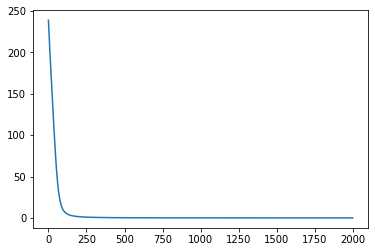

In [158]:
plt.figure()
plt.plot(losses)

In [159]:
model.eval()

CBOW(
  (embeddings): Embedding(49, 16)
  (linear1): Linear(in_features=16, out_features=128, bias=True)
  (activation_function1): ReLU()
  (linear2): Linear(in_features=128, out_features=49, bias=True)
  (activation_function2): LogSoftmax(dim=-1)
)

In [160]:
def next_word(context, model):
    
    vector = model.get_embeddings(make_context_vector(context, word_to_ix))
        
    best_word = None
    best_simy = -1
    
    for vword in vocab:
        
        if vword in context:
            continue
            
        v = model.get_embeddings(make_context_vector(vword, word_to_ix))
        
        s = similarity(vector, v)
        
        if best_word is None:
            best_word = vword
            best_simy = s
        
        if s > best_simy:
            best_word = vword
            best_simy = s
            
    return best_word, best_simy.item()
    

def evaluate(context, model):
    context_vector = make_context_vector(context, word_to_ix)
    a = model(context_vector)

    print(f'Context: {context}')
    print(f'Prediction: {ix_to_word[torch.argmax(a[0]).item()]}')

In [161]:
"""We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells."""


evaluate(['People', 'study'], model)
print('\n')
evaluate(['idea', 'process'], model)
print('\n')
evaluate(['beings', 'People'], model)
print('\n')
evaluate(['pattern', 'process', 'computer'], model)
print('\n')
evaluate(['computational'], model)
print('\n')

Context: ['People', 'study']
Prediction: create


Context: ['idea', 'process']
Prediction: of


Context: ['beings', 'People']
Prediction: programs


Context: ['pattern', 'process', 'computer']
Prediction: about


Context: ['computational']
Prediction: a




In [162]:
for word in vocab:
    print(word, next_word([word], model))

direct ('manipulate', 0.48209720849990845)
the ('about', 0.3668060302734375)
by ('with', 0.5760161280632019)
program. ('things', 0.4989606738090515)
inhabit ('pattern', 0.5285772085189819)
As ('conjure', 0.4363301992416382)
spirits ('study', 0.7306721806526184)
that ('evolution', 0.7505890727043152)
evolution ('that', 0.7505890727043152)
programs ('beings', 0.4174237549304962)
The ('We', 0.5466554164886475)
computational ('effect,', 0.48458290100097656)
abstract ('things', 0.7316676378250122)
other ('In', 0.37484100461006165)
beings ('We', 0.5407030582427979)
are ('evolve,', 0.5538862943649292)
Computational ('directed', 0.7081249356269836)
data. ('In', 0.6790127158164978)
to ('conjure', 0.5540122389793396)
computers. ('we', 0.6065623164176941)
things ('abstract', 0.7316676378250122)
manipulate ('direct', 0.48209720849990845)
rules ('is', 0.5940141677856445)
processes ('data.', 0.6587375998497009)
process ('computational', 0.4451178312301636)
a ('our', 0.41864243149757385)
of ('abstrac